In [1]:
from pyspark.sql.types import *

In [2]:
customSchema = StructType([
    StructField("Primary_Index", IntegerType(), True), 
    StructField("Tweet_Id", StringType(), True), 
    StructField("Date_Text", StringType(), True),
    StructField("Flag", StringType(), True), 
    StructField("User", StringType(), True),
    StructField("Tweet_Text", StringType(), True)])

df = spark.read.load('hdfs://localhost:9000/CA2/ProjectTweets.csv', format="csv", header="False", sep=',', schema=customSchema)



In [3]:
##Remove commas from the Tweet Text field
##First test an example

In [4]:
filtered_df = df.filter(df["Tweet_Id"] == '1467811594')
# Select only the "Tweet_Text" column from the filtered DataFrame
result = filtered_df.select("Tweet_Text")

# Show the content of column "Tweet_Text"
result.show(truncate=False)

+---------------------------------------------------------------------------------------------------+
|Tweet_Text                                                                                         |
+---------------------------------------------------------------------------------------------------+
|@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?|
+---------------------------------------------------------------------------------------------------+



In [5]:
##Then strip the commas out

In [6]:
from pyspark.sql.functions import regexp_replace
# Remove commas from the "Tweet_Text" column

filtered_df = df.filter(df["Tweet_Id"] == '1467811594')

filtered_df = filtered_df.withColumn("Tweet_Text", regexp_replace(filtered_df["Tweet_Text"], ",", ""))

# Select only the "Tweet_Text" column from the filtered DataFrame
result = filtered_df.select("Tweet_Text")

# Show the content of column "Tweet_Text"
result.show(truncate=False)

+------------------------------------------------------------------------------------------------+
|Tweet_Text                                                                                      |
+------------------------------------------------------------------------------------------------+
|@LOLTrish hey  long time no see! Yes.. Rains a bit only a bit  LOL  I'm fine thanks  how's you ?|
+------------------------------------------------------------------------------------------------+



In [7]:
##Now do it with all the rows

In [8]:
df = df.withColumn("Tweet_Text", regexp_replace(df["Tweet_Text"], ",", ""))

In [9]:
filtered_df = df.filter(df["Tweet_Id"] == '1467811594')
# Select only the "Tweet_Text" column from the filtered DataFrame
result = filtered_df.select("Tweet_Text")

# Show the content of column "Tweet_Text"
result.show(truncate=False)

+------------------------------------------------------------------------------------------------+
|Tweet_Text                                                                                      |
+------------------------------------------------------------------------------------------------+
|@LOLTrish hey  long time no see! Yes.. Rains a bit only a bit  LOL  I'm fine thanks  how's you ?|
+------------------------------------------------------------------------------------------------+



In [10]:

# Calculate the max length of each column
from pyspark.sql.functions import max, length
max_lengths = []

for column_name in df.columns:
    max_length = df.agg(max(length(column_name))).collect()[0][0]
    max_lengths.append((column_name, max_length))

# Display the results
for col, max_len in max_lengths:
    print(f"Max length of {col}: {max_len}")

Max length of Primary_Index: 7
Max length of Tweet_Id: 10
Max length of Date_Text: 28
Max length of Flag: 8
Max length of User: 15
Max length of Tweet_Text: 374


In [11]:
from pyspark.sql.functions import col, sum

# Count null values in each column
null_counts = []

for column_name in df.columns:
    count = df.select(column_name).where(col(column_name).isNull()).count()
    null_counts.append((column_name, count))

# Display the results
for col, count in null_counts:
    print(f"Number of null values in {col}: {count}")

Number of null values in Primary_Index: 0
Number of null values in Tweet_Id: 0
Number of null values in Date_Text: 0
Number of null values in Flag: 0
Number of null values in User: 0
Number of null values in Tweet_Text: 0


In [12]:
from pyspark.sql.functions import countDistinct

# Calculate the number of unique values in each column
unique_counts = []

for column_name in df.columns:
    count = df.agg(countDistinct(column_name)).collect()[0][0]
    unique_counts.append((column_name, count))

# Display the results
for col, count in unique_counts:
    print(f"Number of unique values in {col}: {count}")

Number of unique values in Primary_Index: 1600000
Number of unique values in Tweet_Id: 1598315
Number of unique values in Date_Text: 774363
Number of unique values in Flag: 1
Number of unique values in User: 659775
Number of unique values in Tweet_Text: 1581312


In [13]:
from pyspark.sql.functions import col
# Find and display an example record with duplicated "Tweet_Id"
duplicate_tweet_id_example = df.groupBy("Tweet_Id").count().filter(col("count") > 1).limit(1)

# Display the result
duplicate_tweet_id_example.show()

+----------+-----+
|  Tweet_Id|count|
+----------+-----+
|1469531660|    2|
+----------+-----+



In [14]:
# Find and display all records with the Tweet_Id "1469531660"
matching_records = df.filter(col("Tweet_Id") == "1469531660")

# Display the matching records
matching_records.show(truncate=False)

+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+
|Primary_Index|Tweet_Id  |Date_Text                   |Flag    |User        |Tweet_Text                                                       |
+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+
|6730         |1469531660|Tue Apr 07 06:39:53 PDT 2009|NO_QUERY|appleaddicto|Company blocked Twitter today  oh well i still have it on mobile |
|809639       |1469531660|Tue Apr 07 06:39:53 PDT 2009|NO_QUERY|appleaddicto|Company blocked Twitter today  oh well i still have it on mobile |
+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+



In [15]:
# Create a DataFrame with unique records
unique_records_df = df.dropDuplicates(["Tweet_Id", "Date_Text", "Flag", "User", "Tweet_Text"])


In [16]:
# Calculate the number of unique values in each column
unique_counts = []

for column_name in df.columns:
    count = unique_records_df.agg(countDistinct(column_name)).collect()[0][0]
    unique_counts.append((column_name, count))

# Display the results
for col, count in unique_counts:
    print(f"Number of unique values in {col}: {count}")

2023-11-06 19:27:48,571 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:27:48,672 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:27:48,942 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:27:49,102 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Number of unique values in Primary_Index: 1598315
Number of unique values in Tweet_Id: 1598315
Number of unique values in Date_Text: 774363
Number of unique values in Flag: 1
Number of unique values in User: 659775
Number of unique values in Tweet_Text: 1581312


In [17]:
from pyspark.sql.functions import col
# Find and display all records with the Tweet_Id "1469531660"
matching_records = unique_records_df.filter(col("Tweet_Id") == "1469531660")

# Display the matching records
matching_records.show(truncate=False)

2023-11-06 19:28:31,248 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:31,381 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:31,618 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:31,716 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+
|Primary_Index|Tweet_Id  |Date_Text                   |Flag    |User        |Tweet_Text                                                       |
+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+
|6730         |1469531660|Tue Apr 07 06:39:53 PDT 2009|NO_QUERY|appleaddicto|Company blocked Twitter today  oh well i still have it on mobile |
+-------------+----------+----------------------------+--------+------------+-----------------------------------------------------------------+



In [18]:
df = unique_records_df

In [19]:
# Extract characters at positions 21, 22, and 23 and select unique values
from pyspark.sql.functions import substring
unique_characters = df.select(substring("Date_Text", 21, 3).alias("Date_Text_Characters")).distinct()

# Show the unique characters
unique_characters.show()

+--------------------+
|Date_Text_Characters|
+--------------------+
|                 PDT|
+--------------------+



In [20]:

df =df.withColumn("Year", df.Date_Text.substr(-4, 4))
df = df.withColumn("Month", df.Date_Text.substr(5, 3))
df = df.withColumn("Day", df.Date_Text.substr(9, 2))

In [21]:
df.show(10)

2023-11-06 19:28:52,781 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:52,820 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:53,129 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:28:53,155 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+
|Primary_Index|  Tweet_Id|           Date_Text|    Flag|          User|          Tweet_Text|Year|Month|Day|
+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+
|          263|1467878557|Mon Apr 06 22:37:...|NO_QUERY|    tshamysboo|dierks bentley is...|2009|  Apr| 06|
|          679|1467982795|Mon Apr 06 23:06:...|NO_QUERY|      TiffinyB|I am home missing...|2009|  Apr| 06|
|         1354|1468135579|Mon Apr 06 23:54:...|NO_QUERY|       sasi263|On a diet.... Wok...|2009|  Apr| 06|
|         1486|1468163163|Tue Apr 07 00:03:...|NO_QUERY|     olivejina|        @oishiieats |2009|  Apr| 07|
|         1636|1468201547|Tue Apr 07 00:16:...|NO_QUERY|      dirrtyxx|@Kal_Penn OMG I a...|2009|  Apr| 07|
|         1685|1468210391|Tue Apr 07 00:19:...|NO_QUERY|        mistac|Back at :work hav...|2009|  Apr| 07|
|         1787|1468233030|Tu

In [22]:
# Use the `distinct` method to get unique values in the "Month" column
unique_months = df.select("Month").distinct()

# Show the unique values
unique_months.show()

+-----+
|Month|
+-----+
|  May|
|  Jun|
|  Apr|
+-----+



In [23]:
from pyspark.sql.functions import when, lit

# Use the `when` and `lit` functions to replace values in the "Month" column
df = df.withColumn("Month", when(df["Month"] == "May", lit("05"))
                        .when(df["Month"] == "Apr", lit("04"))
                        .when(df["Month"] == "Jun", lit("06"))
                        .otherwise(df["Month"]))

# Show the updated DataFrame
df.show(10)

2023-11-06 19:29:11,638 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:11,924 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:12,037 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:12,418 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+
|Primary_Index|  Tweet_Id|           Date_Text|    Flag|          User|          Tweet_Text|Year|Month|Day|
+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+
|          263|1467878557|Mon Apr 06 22:37:...|NO_QUERY|    tshamysboo|dierks bentley is...|2009|   04| 06|
|          679|1467982795|Mon Apr 06 23:06:...|NO_QUERY|      TiffinyB|I am home missing...|2009|   04| 06|
|         1354|1468135579|Mon Apr 06 23:54:...|NO_QUERY|       sasi263|On a diet.... Wok...|2009|   04| 06|
|         1486|1468163163|Tue Apr 07 00:03:...|NO_QUERY|     olivejina|        @oishiieats |2009|   04| 07|
|         1636|1468201547|Tue Apr 07 00:16:...|NO_QUERY|      dirrtyxx|@Kal_Penn OMG I a...|2009|   04| 07|
|         1685|1468210391|Tue Apr 07 00:19:...|NO_QUERY|        mistac|Back at :work hav...|2009|   04| 07|
|         1787|1468233030|Tu

In [24]:
from pyspark.sql.functions import concat_ws, expr
from pyspark.sql.types import StringType

# Convert the "Year," "Month," and "Day" columns to string type
df = df.withColumn("Year", df["Year"].cast(StringType()))
df = df.withColumn("Month", df["Month"].cast(StringType()))
df = df.withColumn("Day", df["Day"].cast(StringType()))

# Use `concat_ws` to concatenate the three columns with "/" separator
df = df.withColumn("Date", concat_ws("/", df["Day"], df["Month"], df["Year"]))

# Use `expr` to cast the concatenated string to a date
df = df.withColumn("Date", expr("to_date(Date, 'dd/MM/yyyy')"))

# Show the updated DataFrame
df.show(10)

2023-11-06 19:29:25,672 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:25,818 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:25,989 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:26,109 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+----------+
|Primary_Index|  Tweet_Id|           Date_Text|    Flag|          User|          Tweet_Text|Year|Month|Day|      Date|
+-------------+----------+--------------------+--------+--------------+--------------------+----+-----+---+----------+
|          263|1467878557|Mon Apr 06 22:37:...|NO_QUERY|    tshamysboo|dierks bentley is...|2009|   04| 06|2009-04-06|
|          679|1467982795|Mon Apr 06 23:06:...|NO_QUERY|      TiffinyB|I am home missing...|2009|   04| 06|2009-04-06|
|         1354|1468135579|Mon Apr 06 23:54:...|NO_QUERY|       sasi263|On a diet.... Wok...|2009|   04| 06|2009-04-06|
|         1486|1468163163|Tue Apr 07 00:03:...|NO_QUERY|     olivejina|        @oishiieats |2009|   04| 07|2009-04-07|
|         1636|1468201547|Tue Apr 07 00:16:...|NO_QUERY|      dirrtyxx|@Kal_Penn OMG I a...|2009|   04| 07|2009-04-07|
|         1685|1468210391|Tue Apr 07 00:19:...|N

In [25]:
from pyspark.sql.functions import col, lower

df = df.withColumn("Tweet_Text", lower(col("Tweet_Text")))
df.show(10, truncate = False)

2023-11-06 19:29:39,854 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:39,894 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:40,130 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:40,159 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+----------------------------+--------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|Primary_Index|Tweet_Id  |Date_Text                   |Flag    |User          |Tweet_Text                                                                                                                              |Year|Month|Day|Date      |
+-------------+----------+----------------------------+--------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|263          |1467878557|Mon Apr 06 22:37:36 PDT 2009|NO_QUERY|tshamysboo    |dierks bentley is comin' to columbus oh!! i wanna go so bad                                                                             |2009|04   |06 |2009-04-06|
|679          |1467982795|Mo

In [26]:
from pyspark.sql.functions import col, regexp_replace
url_pattern = r'(https?://\S+|www\.\S+)'

# Use regexp_replace to remove URLs from the "Tweet_Text" column
df = df.withColumn("Tweet_Text", regexp_replace(col("Tweet_Text"), url_pattern, ''))
df.show(10, truncate = False)

2023-11-06 19:29:53,519 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:53,753 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:53,774 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:29:54,075 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+----------------------------+--------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|Primary_Index|Tweet_Id  |Date_Text                   |Flag    |User          |Tweet_Text                                                                                                                              |Year|Month|Day|Date      |
+-------------+----------+----------------------------+--------+--------------+----------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|263          |1467878557|Mon Apr 06 22:37:36 PDT 2009|NO_QUERY|tshamysboo    |dierks bentley is comin' to columbus oh!! i wanna go so bad                                                                             |2009|04   |06 |2009-04-06|
|679          |1467982795|Mo

In [27]:
from pyspark.sql.functions import col, regexp_replace
user_mention_pattern = r'@[\w]+'

# Use regexp_replace to remove user mentions from the "Tweet_Text" column
df = df.withColumn("Tweet_Text", regexp_replace(col("Tweet_Text"), user_mention_pattern, ''))
df.show(10, truncate = False)

2023-11-06 19:30:07,312 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:30:07,386 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:30:07,542 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
2023-11-06 19:30:07,663 WARN expressions.RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+-------------+----------+----------------------------+--------+--------------+------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|Primary_Index|Tweet_Id  |Date_Text                   |Flag    |User          |Tweet_Text                                                                                                                          |Year|Month|Day|Date      |
+-------------+----------+----------------------------+--------+--------------+------------------------------------------------------------------------------------------------------------------------------------+----+-----+---+----------+
|263          |1467878557|Mon Apr 06 22:37:36 PDT 2009|NO_QUERY|tshamysboo    |dierks bentley is comin' to columbus oh!! i wanna go so bad                                                                         |2009|04   |06 |2009-04-06|
|679          |1467982795|Mon Apr 06 23:06:4

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-11-06 19:30:19.930929: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 19:30:20.333352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 19:30:20.333395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 19:30:20.335123: E tensorflow/compiler/xla/stream_executor/cuda

In [29]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [30]:
final_df = df[['Tweet_Id', 'Date', 'Tweet_Text']]
sentiment_df = final_df.toPandas()

In [31]:
sentiment_df.head(10)

,Tweet_Id,Date,Tweet_Text
0,1467878557,2009-04-06,dierks bentley is comin' to columbus oh!! i wa...
1,1467901424,2009-04-06,this latest episode of newnownext is like full...
2,1467918595,2009-04-06,casting director called me today she's wicked...
3,1467982795,2009-04-06,i am home missing my baby busy week ahead fri...
4,1468020773,2009-04-06,good post.
5,1468021367,2009-04-06,back on the 7am train ... rubbish! only for 3 ...
6,1468023239,2009-04-06,day 2 is almost over! i can't wait to eat wad...
7,1468036593,2009-04-06,i'm sure if i saw you i'd think you're way li...
8,1468071517,2009-04-06,is there twitter for francophones? maybe i wo...
9,1468087930,2009-04-06,is eating frozen grapes in an effort to fill i...


In [32]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Print the formatted date and time
print("Current date and time:", formatted_datetime)

Current date and time: 2023-11-06 19:31:18


In [33]:
sentiment_df['Tweet_Text_Cleaned'] = sentiment_df['Tweet_Text'].apply(get_text_processing)
sentiment_df.head()

,Tweet_Id,Date,Tweet_Text,Tweet_Text_Cleaned
0,1467878557,2009-04-06,dierks bentley is comin' to columbus oh!! i wa...,dierks bentley comin columbus oh wanna go bad
1,1467901424,2009-04-06,this latest episode of newnownext is like full...,latest episode newnownext like full awesome
2,1467918595,2009-04-06,casting director called me today she's wicked...,casting director called today shes wicked exci...
3,1467982795,2009-04-06,i am home missing my baby busy week ahead fri...,home missing baby busy week ahead fri chill da...
4,1468020773,2009-04-06,good post.,good post


In [34]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Print the formatted date and time
print("Current date and time:", formatted_datetime)

Current date and time: 2023-11-06 19:38:50


In [35]:
import pandas as pd
from textblob import TextBlob

# Assuming "df" is your Pandas DataFrame
sentiment_df["Textblob_Sentiment"] = sentiment_df["Tweet_Text_Cleaned"].apply(lambda x: TextBlob(x).sentiment.polarity)

# The "Sentiment" column now contains sentiment polarity scores


In [36]:
def classify_sentiment(polarity):
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

sentiment_df["Textblob_Sentiment_Class"] = sentiment_df["Textblob_Sentiment"].apply(classify_sentiment)

In [37]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Print the formatted date and time
print("Current date and time:", formatted_datetime)

Current date and time: 2023-11-06 19:45:53


In [38]:
import nltk
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming "df" is your Pandas DataFrame
sentiment_df["NLTK_Sentiment_Scores"] = sentiment_df["Tweet_Text_Cleaned"].apply(lambda x: analyzer.polarity_scores(x))

# Extract the sentiment scores (positive, negative, neutral, compound) into separate columns
sentiment_df["NLTK_Positive_Score"] = sentiment_df["NLTK_Sentiment_Scores"].apply(lambda x: x["pos"])
sentiment_df["NLTK_Negative_Score"] = sentiment_df["NLTK_Sentiment_Scores"].apply(lambda x: x["neg"])
sentiment_df["NLTK_Neutral_Score"] = sentiment_df["NLTK_Sentiment_Scores"].apply(lambda x: x["neu"])
sentiment_df["NLTK_Compound_Score"] = sentiment_df["NLTK_Sentiment_Scores"].apply(lambda x: x["compound"])

# Classify sentiment based on compound score
sentiment_df["NLTK_Sentiment_Class"] = sentiment_df["NLTK_Compound_Score"].apply(lambda x: "Positive" if x > 0 else "Negative" if x < 0 else "Neutral")



In [39]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M:%S')

# Print the formatted date and time
print("Current date and time:", formatted_datetime)

Current date and time: 2023-11-06 19:51:36


In [40]:
sentiment_df.head()

,Tweet_Id,Date,Tweet_Text,Tweet_Text_Cleaned,Textblob_Sentiment,Textblob_Sentiment_Class,NLTK_Sentiment_Scores,NLTK_Positive_Score,NLTK_Negative_Score,NLTK_Neutral_Score,NLTK_Compound_Score,NLTK_Sentiment_Class
0,1467878557,2009-04-06,dierks bentley is comin' to columbus oh!! i wa...,dierks bentley comin columbus oh wanna go bad,-0.700000,Negative,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",0.000,0.333,0.667,-0.5423,Negative
1,1467901424,2009-04-06,this latest episode of newnownext is like full...,latest episode newnownext like full awesome,0.616667,Positive,"{'neg': 0.0, 'neu': 0.377, 'pos': 0.623, 'comp...",0.623,0.000,0.377,0.7650,Positive
2,1467918595,2009-04-06,casting director called me today she's wicked...,casting director called today shes wicked exci...,-0.062500,Negative,"{'neg': 0.301, 'neu': 0.583, 'pos': 0.117, 'co...",0.117,0.301,0.583,-0.5859,Negative
3,1467982795,2009-04-06,i am home missing my baby busy week ahead fri...,home missing baby busy week ahead fri chill da...,-0.050000,Negative,"{'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'comp...",0.000,0.109,0.891,-0.2960,Negative
4,1468020773,2009-04-06,good post.,good post,0.700000,Positive,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.744,0.000,0.256,0.4404,Positive


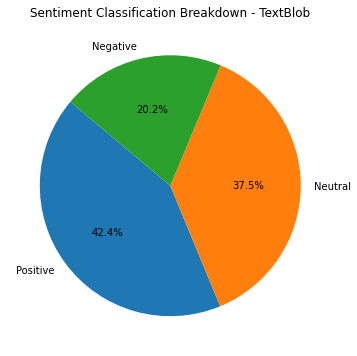

In [41]:
import matplotlib.pyplot as plt

sentiment_counts = sentiment_df['Textblob_Sentiment_Class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Classification Breakdown - TextBlob')
plt.show()

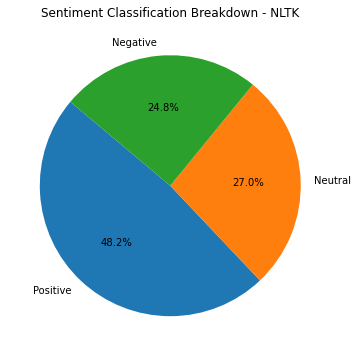

In [42]:

sentiment_counts = sentiment_df['NLTK_Sentiment_Class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Classification Breakdown - NLTK')
plt.show()

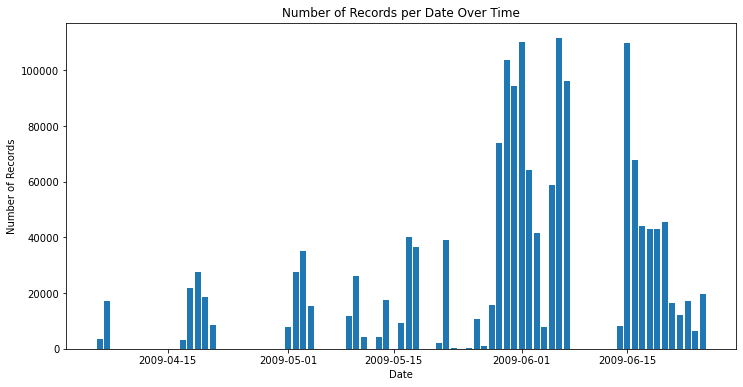

In [43]:
import matplotlib.pyplot as plt
date_counts = sentiment_df['Date'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(date_counts.index, date_counts.values, width=0.8, align='center')

# You can set labels and titles for the chart and axes:
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.title('Number of Records per Date Over Time')

# If you have many dates, you may want to rotate the x-axis labels for better readability:
#plt.xticks(rotation=45)

# Show the chart
plt.show()

In [44]:
print(sentiment_df['Date'].unique())

[datetime.date(2009, 4, 6) datetime.date(2009, 4, 7)
 datetime.date(2009, 4, 17) datetime.date(2009, 4, 18)
 datetime.date(2009, 4, 19) datetime.date(2009, 4, 20)
 datetime.date(2009, 4, 21) datetime.date(2009, 5, 1)
 datetime.date(2009, 5, 2) datetime.date(2009, 5, 3)
 datetime.date(2009, 5, 4) datetime.date(2009, 5, 9)
 datetime.date(2009, 5, 10) datetime.date(2009, 5, 11)
 datetime.date(2009, 5, 13) datetime.date(2009, 5, 14)
 datetime.date(2009, 5, 16) datetime.date(2009, 5, 17)
 datetime.date(2009, 5, 18) datetime.date(2009, 5, 21)
 datetime.date(2009, 5, 22) datetime.date(2009, 5, 23)
 datetime.date(2009, 5, 26) datetime.date(2009, 5, 27)
 datetime.date(2009, 5, 28) datetime.date(2009, 5, 29)
 datetime.date(2009, 5, 30) datetime.date(2009, 5, 31)
 datetime.date(2009, 6, 1) datetime.date(2009, 6, 2)
 datetime.date(2009, 6, 3) datetime.date(2009, 6, 4)
 datetime.date(2009, 6, 5) datetime.date(2009, 6, 6)
 datetime.date(2009, 6, 7) datetime.date(2009, 6, 14)
 datetime.date(2009, 6, 

In [45]:
print(sentiment_df['Date'].sort_values().unique())


[datetime.date(2009, 4, 6) datetime.date(2009, 4, 7)
 datetime.date(2009, 4, 17) datetime.date(2009, 4, 18)
 datetime.date(2009, 4, 19) datetime.date(2009, 4, 20)
 datetime.date(2009, 4, 21) datetime.date(2009, 5, 1)
 datetime.date(2009, 5, 2) datetime.date(2009, 5, 3)
 datetime.date(2009, 5, 4) datetime.date(2009, 5, 9)
 datetime.date(2009, 5, 10) datetime.date(2009, 5, 11)
 datetime.date(2009, 5, 13) datetime.date(2009, 5, 14)
 datetime.date(2009, 5, 16) datetime.date(2009, 5, 17)
 datetime.date(2009, 5, 18) datetime.date(2009, 5, 21)
 datetime.date(2009, 5, 22) datetime.date(2009, 5, 23)
 datetime.date(2009, 5, 25) datetime.date(2009, 5, 26)
 datetime.date(2009, 5, 27) datetime.date(2009, 5, 28)
 datetime.date(2009, 5, 29) datetime.date(2009, 5, 30)
 datetime.date(2009, 5, 31) datetime.date(2009, 6, 1)
 datetime.date(2009, 6, 2) datetime.date(2009, 6, 3)
 datetime.date(2009, 6, 4) datetime.date(2009, 6, 5)
 datetime.date(2009, 6, 6) datetime.date(2009, 6, 7)
 datetime.date(2009, 6, 

In [46]:
date_avg_score = sentiment_df.groupby('Date')['Textblob_Sentiment'].mean()

# Reset the index to have 'Date' as a column instead of an index
date_avg_score = date_avg_score.reset_index()

# Display the breakdown
print(date_avg_score)

          Date  Textblob_Sentiment
0   2009-04-06            0.093937
1   2009-04-07            0.099277
2   2009-04-17            0.121680
3   2009-04-18            0.112109
4   2009-04-19            0.115034
5   2009-04-20            0.111517
6   2009-04-21            0.109791
7   2009-05-01            0.111782
8   2009-05-02            0.114817
9   2009-05-03            0.108905
10  2009-05-04            0.110084
11  2009-05-09            0.125939
12  2009-05-10            0.154356
13  2009-05-11            0.106504
14  2009-05-13            0.097716
15  2009-05-14            0.107822
16  2009-05-16            0.109111
17  2009-05-17            0.124288
18  2009-05-18            0.117270
19  2009-05-21            0.109986
20  2009-05-22            0.121363
21  2009-05-23            0.108315
22  2009-05-25            0.152112
23  2009-05-26            0.104736
24  2009-05-27            0.093531
25  2009-05-28            0.116479
26  2009-05-29            0.113387
27  2009-05-30      

In [47]:
date_avg_score = sentiment_df.groupby('Date')['NLTK_Compound_Score'].mean()

# Reset the index to have 'Date' as a column instead of an index
date_avg_score = date_avg_score.reset_index()

# Display the breakdown
print(date_avg_score)

          Date  NLTK_Compound_Score
0   2009-04-06             0.149617
1   2009-04-07             0.168363
2   2009-04-17             0.203692
3   2009-04-18             0.183011
4   2009-04-19             0.188620
5   2009-04-20             0.180237
6   2009-04-21             0.181058
7   2009-05-01             0.179307
8   2009-05-02             0.182975
9   2009-05-03             0.174692
10  2009-05-04             0.169947
11  2009-05-09             0.184752
12  2009-05-10             0.213646
13  2009-05-11             0.166249
14  2009-05-13             0.146755
15  2009-05-14             0.173145
16  2009-05-16             0.173580
17  2009-05-17             0.202065
18  2009-05-18             0.189932
19  2009-05-21             0.177161
20  2009-05-22             0.199820
21  2009-05-23             0.203072
22  2009-05-25             0.189096
23  2009-05-26             0.173951
24  2009-05-27             0.136597
25  2009-05-28             0.186978
26  2009-05-29             0

In [48]:
# Convert the 'Date' column to datetime if it's not already
date_avg_score['Date'] = pd.to_datetime(date_avg_score['Date'])

# Create a date range from the earliest date to the latest date
date_range = pd.date_range(start=date_avg_score['Date'].min(), end=date_avg_score['Date'].max())

# Create a DataFrame with the date range
date_df = pd.DataFrame({'Date': date_range})

# Merge the date_df with date_avg_score to include the 'NLTK_Compound_Score'
merged_df = date_df.merge(date_avg_score, on='Date', how='left')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Print the DataFrame
print(merged_df)



         Date  NLTK_Compound_Score
0  2009-04-06             0.149617
1  2009-04-07             0.168363
2  2009-04-08                  NaN
3  2009-04-09                  NaN
4  2009-04-10                  NaN
5  2009-04-11                  NaN
6  2009-04-12                  NaN
7  2009-04-13                  NaN
8  2009-04-14                  NaN
9  2009-04-15                  NaN
10 2009-04-16                  NaN
11 2009-04-17             0.203692
12 2009-04-18             0.183011
13 2009-04-19             0.188620
14 2009-04-20             0.180237
15 2009-04-21             0.181058
16 2009-04-22                  NaN
17 2009-04-23                  NaN
18 2009-04-24                  NaN
19 2009-04-25                  NaN
20 2009-04-26                  NaN
21 2009-04-27                  NaN
22 2009-04-28                  NaN
23 2009-04-29                  NaN
24 2009-04-30                  NaN
25 2009-05-01             0.179307
26 2009-05-02             0.182975
27 2009-05-03       

In [49]:
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

In [50]:
print(merged_df['NLTK_Compound_Score'].isna().sum())

33


In [51]:
imputation_orig_df = merged_df[(merged_df['Date'] >= '2009-05-25') & (merged_df['Date'] <= '2009-06-07')]
imputation_orig_df.rename(columns={'NLTK_Compound_Score': 'True_NLTK_Compound_Score'}, inplace=True)

imputation_test_df = merged_df[(merged_df['Date'] >= '2009-05-25') & (merged_df['Date'] <= '2009-06-07')]

# Create a list of dates to nullify 'NLTK_Compound_Score'
dates_to_nullify = ['2009-05-28', '2009-05-29', '2009-05-30', '2009-06-05']

# Nullify 'NLTK_Compound_Score' for the specified dates
imputation_test_df.loc[imputation_test_df['Date'].isin(dates_to_nullify), 'NLTK_Compound_Score'] = None

imputation_orig_df = imputation_orig_df.set_index('Date')
imputation_test_df = imputation_test_df.set_index('Date')

# Print the resulting DataFrame
print(imputation_orig_df)
print(imputation_test_df)


            True_NLTK_Compound_Score
Date                                
2009-05-25                  0.189096
2009-05-26                  0.173951
2009-05-27                  0.136597
2009-05-28                  0.186978
2009-05-29                  0.186387
2009-05-30                  0.192508
2009-05-31                  0.193986
2009-06-01                  0.175798
2009-06-02                  0.177499
2009-06-03                  0.174381
2009-06-04                  0.161690
2009-06-05                  0.186587
2009-06-06                  0.183182
2009-06-07                  0.183803
            NLTK_Compound_Score
Date                           
2009-05-25             0.189096
2009-05-26             0.173951
2009-05-27             0.136597
2009-05-28                  NaN
2009-05-29                  NaN
2009-05-30                  NaN
2009-05-31             0.193986
2009-06-01             0.175798
2009-06-02             0.177499
2009-06-03             0.174381
2009-06-04             0

/tmp/ipykernel_4125/3900029485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputation_orig_df.rename(columns={'NLTK_Compound_Score': 'True_NLTK_Compound_Score'}, inplace=True)


In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
df_ffill = imputation_test_df.ffill()
mse_ffill = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], df_ffill['NLTK_Compound_Score'])


df_bfill = imputation_test_df.bfill()
mse_bfill = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], df_bfill['NLTK_Compound_Score'])


## 4. Linear Interpolation ------------------
imputation_test_df['rownum'] = np.arange(imputation_test_df.shape[0])
df_nona = imputation_test_df.dropna(subset = ['NLTK_Compound_Score'])
f = interp1d(df_nona['rownum'], df_nona['NLTK_Compound_Score'])
imputation_test_df['linear_fill'] = f(imputation_test_df['rownum'])
mse_linearI = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], imputation_test_df['linear_fill'])


## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['NLTK_Compound_Score'], kind='cubic')
imputation_test_df['cubic_fill'] = f2(imputation_test_df['rownum'])
mse_CubicI = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], imputation_test_df['cubic_fill'])



## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

imputation_test_df['knn_mean'] = knn_mean(imputation_test_df.NLTK_Compound_Score.values, 8)

mse_knn = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], imputation_test_df['knn_mean'])


## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

imputation_test_df['seasonal_mean'] = seasonal_mean(imputation_test_df.NLTK_Compound_Score, n=1, lr=1.25)
mse_seasonal_mean = mean_squared_error(imputation_orig_df['True_NLTK_Compound_Score'], imputation_test_df['seasonal_mean'])



print(imputation_test_df)

            NLTK_Compound_Score  rownum  linear_fill  cubic_fill  knn_mean  \
Date                                                                         
2009-05-25             0.189096       0     0.189096    0.189096  0.189096   
2009-05-26             0.173951       1     0.173951    0.173951  0.173951   
2009-05-27             0.136597       2     0.136597    0.136597  0.136597   
2009-05-28                  NaN       3     0.150944    0.134052  0.173408   
2009-05-29                  NaN       4     0.165291    0.158657  0.173886   
2009-05-30                  NaN       5     0.179639    0.186578  0.171566   
2009-05-31             0.193986       6     0.193986    0.193986  0.193986   
2009-06-01             0.175798       7     0.175798    0.175798  0.175798   
2009-06-02             0.177499       8     0.177499    0.177499  0.177499   
2009-06-03             0.174381       9     0.174381    0.174381  0.174381   
2009-06-04             0.161690      10     0.161690    0.161690

In [53]:
print(mse_ffill)
print(mse_bfill)
print(mse_linearI)
print(mse_CubicI)
print(mse_seasonal_mean)

0.0006259520432471975
8.616093661843164e-06
0.0001506691008618628
0.0002816987668740227
0.00014580574435655094


In [54]:
# Merge 'NLTK_Compound_Score' from 'imputation_orig_df' into 'imputation_test_df' based on the 'Date' index
imputation_test_df = imputation_test_df.merge(imputation_orig_df[['True_NLTK_Compound_Score']], left_index=True, right_index=True, suffixes=('', '_orig'))
print(imputation_test_df)


            NLTK_Compound_Score  rownum  linear_fill  cubic_fill  knn_mean  \
Date                                                                         
2009-05-25             0.189096       0     0.189096    0.189096  0.189096   
2009-05-26             0.173951       1     0.173951    0.173951  0.173951   
2009-05-27             0.136597       2     0.136597    0.136597  0.136597   
2009-05-28                  NaN       3     0.150944    0.134052  0.173408   
2009-05-29                  NaN       4     0.165291    0.158657  0.173886   
2009-05-30                  NaN       5     0.179639    0.186578  0.171566   
2009-05-31             0.193986       6     0.193986    0.193986  0.193986   
2009-06-01             0.175798       7     0.175798    0.175798  0.175798   
2009-06-02             0.177499       8     0.177499    0.177499  0.177499   
2009-06-03             0.174381       9     0.174381    0.174381  0.174381   
2009-06-04             0.161690      10     0.161690    0.161690

In [55]:
merged_df_bfill = merged_df.bfill()
#merged_df_bfill = merged_df_bfill.set_index('Date')
print(merged_df_bfill)
type(merged_df_bfill)

         Date  NLTK_Compound_Score
0  2009-04-06             0.149617
1  2009-04-07             0.168363
2  2009-04-08             0.203692
3  2009-04-09             0.203692
4  2009-04-10             0.203692
5  2009-04-11             0.203692
6  2009-04-12             0.203692
7  2009-04-13             0.203692
8  2009-04-14             0.203692
9  2009-04-15             0.203692
10 2009-04-16             0.203692
11 2009-04-17             0.203692
12 2009-04-18             0.183011
13 2009-04-19             0.188620
14 2009-04-20             0.180237
15 2009-04-21             0.181058
16 2009-04-22             0.179307
17 2009-04-23             0.179307
18 2009-04-24             0.179307
19 2009-04-25             0.179307
20 2009-04-26             0.179307
21 2009-04-27             0.179307
22 2009-04-28             0.179307
23 2009-04-29             0.179307
24 2009-04-30             0.179307
25 2009-05-01             0.179307
26 2009-05-02             0.182975
27 2009-05-03       

pandas.core.frame.DataFrame

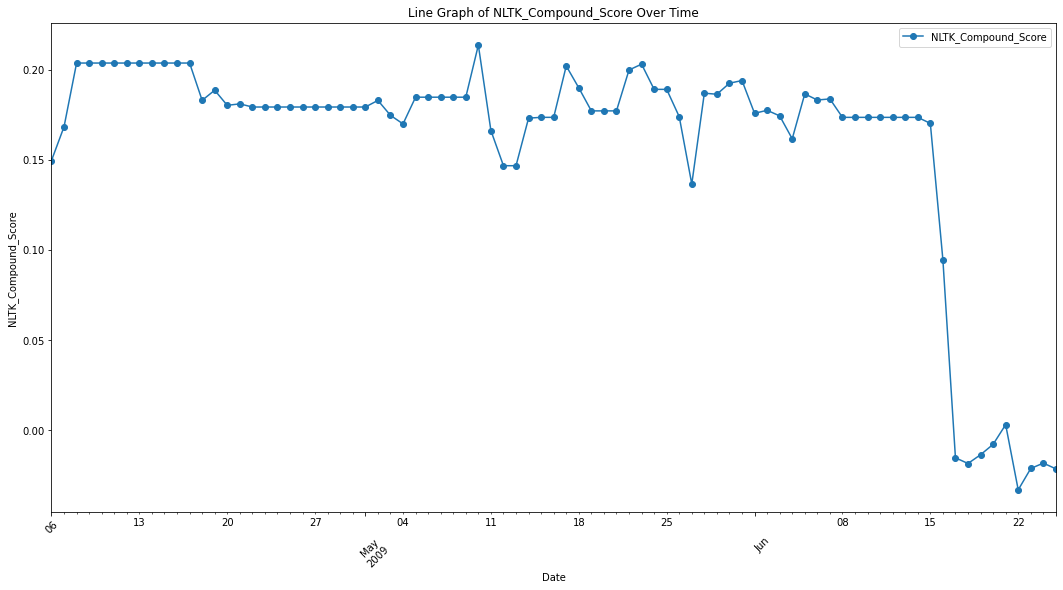

In [56]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(merged_df_bfill)
df['Date'] = pd.to_datetime(df['Date'])

# Create a line graph
df.plot(x='Date', y='NLTK_Compound_Score', figsize=(18, 9), marker='o', linestyle='-')
plt.title('Line Graph of NLTK_Compound_Score Over Time')
plt.xlabel('Date')
plt.ylabel('NLTK_Compound_Score')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

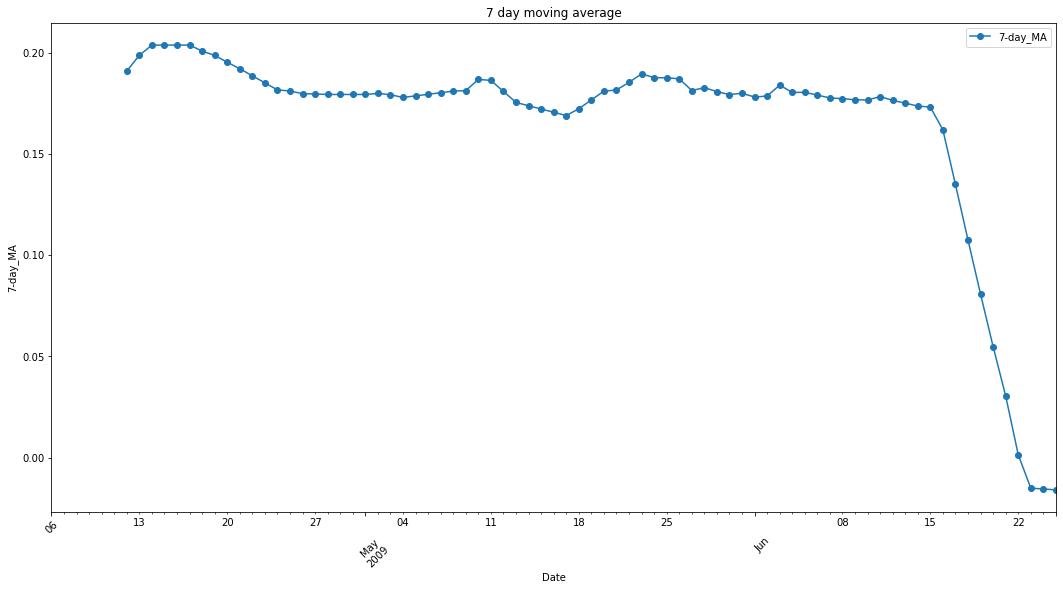

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df_bfill['7-day_MA'] = merged_df_bfill['NLTK_Compound_Score'].rolling(window=7).mean()
#merged_df_bfill['7-day_MA'] = merged_df_bfill['7-day_MA'].bfill()

df = pd.DataFrame(merged_df_bfill)
df['Date'] = pd.to_datetime(df['Date'])

# Create a line graph
df.plot(x='Date', y='7-day_MA', figsize=(18, 9), marker='o', linestyle='-')
plt.title('7 day moving average')
plt.xlabel('Date')
plt.ylabel('7-day_MA')

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [58]:
print(merged_df_bfill)

         Date  NLTK_Compound_Score  7-day_MA
0  2009-04-06             0.149617       NaN
1  2009-04-07             0.168363       NaN
2  2009-04-08             0.203692       NaN
3  2009-04-09             0.203692       NaN
4  2009-04-10             0.203692       NaN
5  2009-04-11             0.203692       NaN
6  2009-04-12             0.203692  0.190920
7  2009-04-13             0.203692  0.198645
8  2009-04-14             0.203692  0.203692
9  2009-04-15             0.203692  0.203692
10 2009-04-16             0.203692  0.203692
11 2009-04-17             0.203692  0.203692
12 2009-04-18             0.183011  0.200738
13 2009-04-19             0.188620  0.198585
14 2009-04-20             0.180237  0.195234
15 2009-04-21             0.181058  0.192000
16 2009-04-22             0.179307  0.188517
17 2009-04-23             0.179307  0.185033
18 2009-04-24             0.179307  0.181550
19 2009-04-25             0.179307  0.181020
20 2009-04-26             0.179307  0.179690
21 2009-04

In [60]:
merged_df_bfill = merged_df.bfill()
merged_df_bfill = merged_df_bfill.set_index('Date')
print(merged_df_bfill)


            NLTK_Compound_Score
Date                           
2009-04-06             0.149617
2009-04-07             0.168363
2009-04-08             0.203692
2009-04-09             0.203692
2009-04-10             0.203692
2009-04-11             0.203692
2009-04-12             0.203692
2009-04-13             0.203692
2009-04-14             0.203692
2009-04-15             0.203692
2009-04-16             0.203692
2009-04-17             0.203692
2009-04-18             0.183011
2009-04-19             0.188620
2009-04-20             0.180237
2009-04-21             0.181058
2009-04-22             0.179307
2009-04-23             0.179307
2009-04-24             0.179307
2009-04-25             0.179307
2009-04-26             0.179307
2009-04-27             0.179307
2009-04-28             0.179307
2009-04-29             0.179307
2009-04-30             0.179307
2009-05-01             0.179307
2009-05-02             0.182975
2009-05-03             0.174692
2009-05-04             0.169947
2009-05-

In [61]:
merged_df_bfill.index

DatetimeIndex(['2009-04-06', '2009-04-07', '2009-04-08', '2009-04-09',
               '2009-04-10', '2009-04-11', '2009-04-12', '2009-04-13',
               '2009-04-14', '2009-04-15', '2009-04-16', '2009-04-17',
               '2009-04-18', '2009-04-19', '2009-04-20', '2009-04-21',
               '2009-04-22', '2009-04-23', '2009-04-24', '2009-04-25',
               '2009-04-26', '2009-04-27', '2009-04-28', '2009-04-29',
               '2009-04-30', '2009-05-01', '2009-05-02', '2009-05-03',
               '2009-05-04', '2009-05-05', '2009-05-06', '2009-05-07',
               '2009-05-08', '2009-05-09', '2009-05-10', '2009-05-11',
               '2009-05-12', '2009-05-13', '2009-05-14', '2009-05-15',
               '2009-05-16', '2009-05-17', '2009-05-18', '2009-05-19',
               '2009-05-20', '2009-05-21', '2009-05-22', '2009-05-23',
               '2009-05-24', '2009-05-25', '2009-05-26', '2009-05-27',
               '2009-05-28', '2009-05-29', '2009-05-30', '2009-05-31',
      

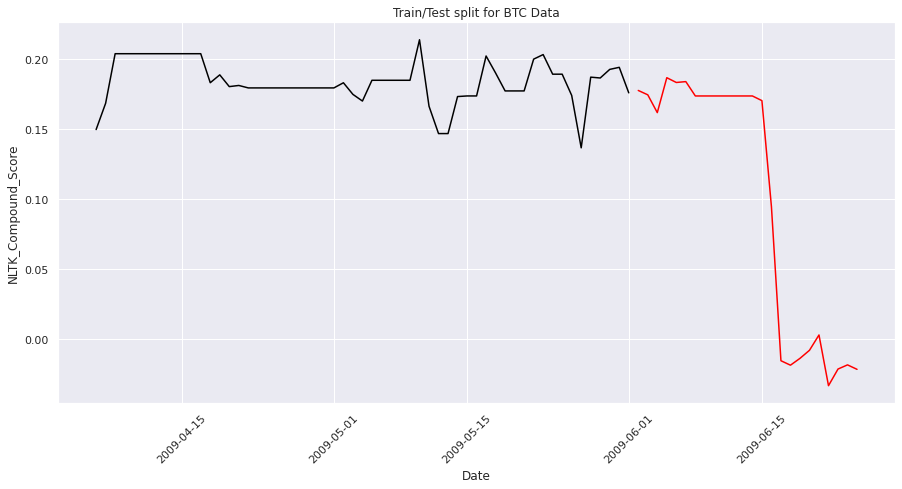

In [77]:
train = merged_df_bfill[merged_df_bfill.index <= pd.to_datetime("2009-06-01", format='%Y-%m-%d')]
test = merged_df_bfill[merged_df_bfill.index > pd.to_datetime("2009-06-01", format='%Y-%m-%d')]
plt.figure(figsize=(15, 7)) 
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('NLTK_Compound_Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.73067D+00    |proj g|=  8.59562D+00

At iterate    5    f= -2.73420D+00    |proj g|=  6.41811D-02

At iterate   10    f= -2.73432D+00    |proj g|=  4.32789D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     31      1     0     0   1.190D-03  -2.734D+00
  F =  -2.7343296076605457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

   evaluations in the last line searc

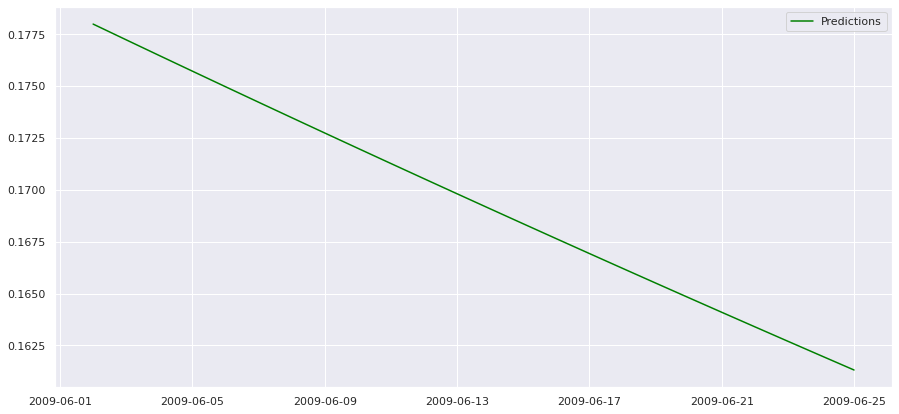

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
y = train['NLTK_Compound_Score']
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
plt.figure(figsize=(15, 7)) 
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='green', label = 'Predictions')

plt.legend()


In [90]:
from statsmodels.tsa.stattools import adfuller

In [93]:
result = adfuller(merged_df_bfill['NLTK_Compound_Score'].values)
adf_statistic = result[0]
p_value = result[1]

# Define a significance level (e.g., 0.05)
significance_level = 0.05

# Summarize the results
if p_value < significance_level:
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Null hypothesis can be rejected. The data is likely stationary.")
else:
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Failed to reject the null hypothesis. The data is likely non-stationary.")

ADF Statistic: -0.006316234289104147
p-value: 0.9580066104410131
Failed to reject the null hypothesis. The data is likely non-stationary.
